### Edgar Moises Hernandez-Gonzalez
#### 11/04/20-03/07/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Escalogramas CWT (3D)
##### Entrada resize proporcional de 495x500
##### 5 ejecuciones independientes

In [1]:
from google.colab import drive

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import pywt
import cv2
# from keras.utils import to_categorical
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [ ]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/EtiquetasA01E.csv", header=None)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [ ]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [ ]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [ ]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# las etiquetas en categorical para poder entrenar data augmentation
# y_train_categorical = to_categorical(y_train)
# y_test_categorical = to_categorical(y_test)

In [ ]:
#unir 22 canales
def unir_escalogramas_vertical(data):
  dim = (500, 495) #ancho, alto
  fs = 250
  escalas = pywt.scale2frequency('cmor3-3', np.arange(8,30.5,0.5)) / (1/fs)
  datos = np.zeros((data.shape[0],495,500))
  temporal = np.zeros((990,1000))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      #sig = sig[124:624]
      # escalograma CWT
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3', sampling_period = (1 / fs))
      temporal[j*45:(j+1)*45, :] = abs(coef)
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [ ]:
#llamar a unir_escalogramas_vertical(data)
inicio = time.time()

x_train = unir_escalogramas_vertical(x_train)
x_test = unir_escalogramas_vertical(x_test)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
200
0
100
200
Tiempo: 197.93678045272827


In [ ]:
print(x_train.shape)
print(x_test.shape)

(288, 495, 500)
(288, 495, 500)


In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

42.74779617032597
32.52460565651963
0.004281350400303023
0.011480774633433078
2.169533356610686
2.1340957045404827


In [ ]:
x = np.ceil(np.max(x_train))

In [ ]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= x
x_test /= x

In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.9941348
0.75638616
9.956629e-05
0.00026699476
0.050454315
0.049630083


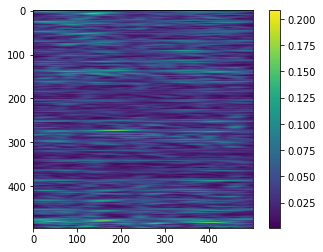

In [ ]:
plt.figure()
plt.imshow(x_train[2])
plt.colorbar()
plt.show()

In [ ]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 495, 500, 1)
(288, 495, 500, 1)


In [ ]:
# datagen_train = ImageDataGenerator(width_shift_range=0.25)

In [ ]:
mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/CWT09.hdf5',
                     monitor='val_accuracy', save_best_only=True, verbose=0)

In [ ]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
loss:  0.8293239308728112
accuracy:  0.75
kappa:  0.6666666666666667
confusion matrix:
 [[63  7  1  1]
 [ 7 46  8 11]
 [ 2 11 47 12]
 [ 4  8  0 60]]


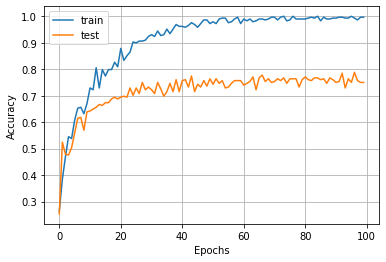

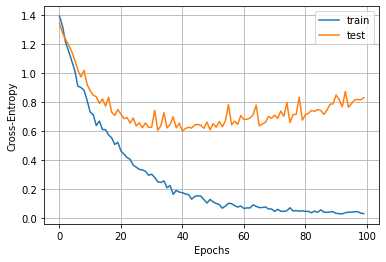

Iteration: 2
loss:  0.957627620961931
accuracy:  0.7534722089767456
kappa:  0.6712962962962963
confusion matrix:
 [[60  7  5  0]
 [ 4 48 15  5]
 [ 1  9 57  5]
 [ 2  4 14 52]]


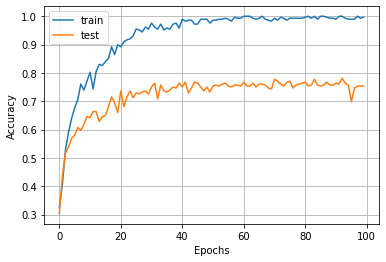

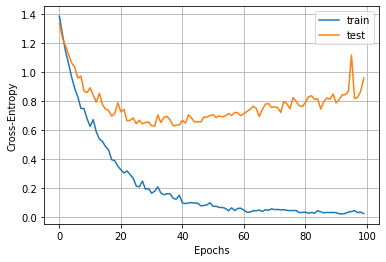

Iteration: 3
loss:  0.7928139964739481
accuracy:  0.7604166865348816
kappa:  0.6805555555555556
confusion matrix:
 [[60 10  1  1]
 [ 5 56  9  2]
 [ 1 11 53  7]
 [ 0 16  6 50]]


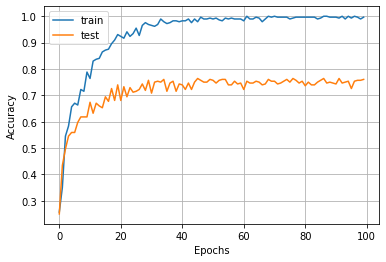

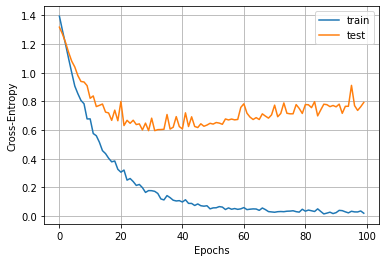

Iteration: 4
loss:  0.7518652677536011
accuracy:  0.7569444179534912
kappa:  0.6759259259259259
confusion matrix:
 [[60  7  4  1]
 [ 5 48 11  8]
 [ 2  9 54  7]
 [ 2  7  7 56]]


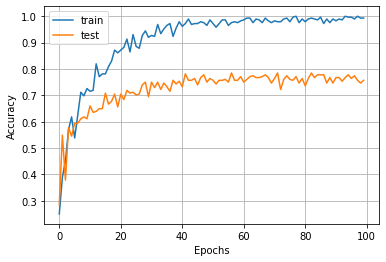

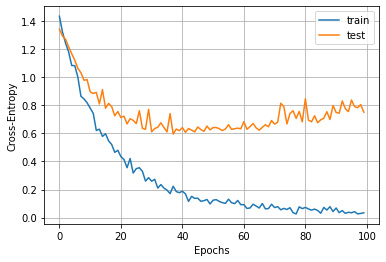

Iteration: 5
loss:  0.8613801234298282
accuracy:  0.7569444179534912
kappa:  0.6759259259259259
confusion matrix:
 [[58 11  2  1]
 [ 5 49 10  8]
 [ 3 10 50  9]
 [ 2  7  2 61]]


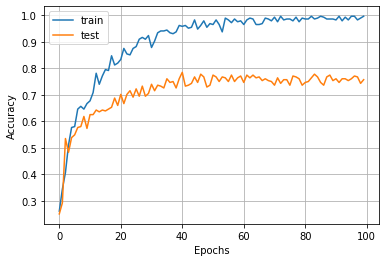

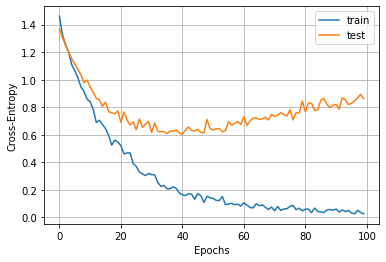


Resultados:
loss: [0.8293239308728112, 0.957627620961931, 0.7928139964739481, 0.7518652677536011, 0.8613801234298282]
accuracy: [0.75, 0.7534722089767456, 0.7604166865348816, 0.7569444179534912, 0.7569444179534912]
kappa: [0.6666666666666667, 0.6712962962962963, 0.6805555555555556, 0.6759259259259259, 0.6759259259259259]
Tiempo: 545.4131429195404


In [ ]:
inicio = time.time()
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  '''history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=36),
                                steps_per_epoch=np.ceil(n_samples_train/36),
                                epochs=400,
                                validation_data=(x_test, y_test_categorical),
                                verbose=0) #, callbacks=[mc])

  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)'''

  history = model.fit(x_train, y_train, epochs=100, batch_size=36,
                      validation_data=(x_test, y_test), verbose=0,
                      callbacks=[mc])
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 495, 500, 16)      160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 247, 250, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 247, 250, 16)      2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 123, 125, 16)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 246000)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               31488128  
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.7556
std: (+/- 0.0035)
Mean Kappa: 0.6741
std: (+/- 0.0047)
Max Accuracy: 0.7604
Max Kappa: 0.6806
Tiempo: 545


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jul  2 08:04:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    50W / 250W |   5157MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------